# Model to predict house prices

### Data Exploration

In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import dagshub

load_dotenv()

dagshub_token = os.getenv("DAGSHUB_TOKEN")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")


df = pd.read_csv("s3://house-price-predictor-dvc/files/Housing.csv")
print(df.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [2]:
target = 'price'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


Inference: The Dataset consists of 13 features & 545 samples.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Dataset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Dataset has 1 numerical & 11 categorical features.


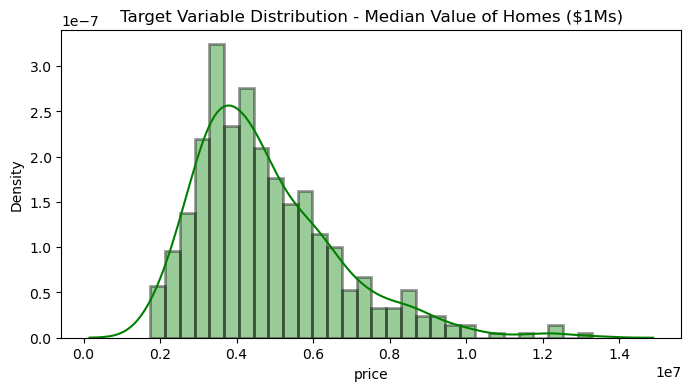

In [5]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

The Target Variable seems to be be normally distributed, averaging around 20 units.

### Data Preprocessing

In [6]:
counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [7]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
price                             0         0.0
area                              0         0.0
bedrooms                          0         0.0
bathrooms                         0         0.0
stories                           0         0.0
mainroad                          0         0.0
guestroom                         0         0.0
basement                          0         0.0
hotwaterheating                   0         0.0
airconditioning                   0         0.0
parking                           0         0.0
prefarea                          0         0.0
furnishingstatus                  0         0.0


In [8]:
df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
df3.shape

One-Hot Encoding on features:
mainroad
guestroom
basement
hotwaterheating
airconditioning
prefarea

Dummy Encoding on features:
furnishingstatus
bathrooms
stories
parking
bedrooms


(545, 24)

In [9]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,13300000,7420,True,False,False,False,True,True,False,False,...,True,False,False,True,False,False,False,True,False,False
1,12250000,8960,True,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,12250000,9960,True,False,True,False,False,True,True,False,...,False,False,False,True,False,False,True,False,False,False
3,12215000,7500,True,False,True,False,True,True,False,False,...,False,False,False,False,True,False,False,True,False,False
4,11410000,7420,True,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False



Inference:
Before removal of outliers, The dataset had 545 samples.
After removal of outliers, The dataset now has 533 samples.


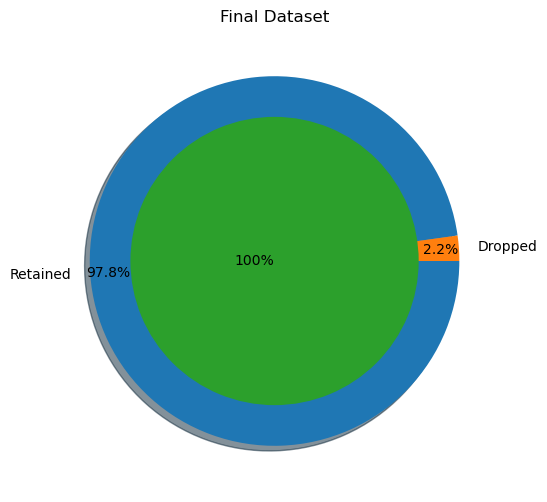


Inference: After the cleanup process, 12 samples were dropped, while retaining 2.2% of the data.


In [10]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()
print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

### Data Manipulation

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [12]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)
print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (533, 23) (533,) 
Training set  --->  (426, 23) (426,) 
Testing set   --->  (107, 23)  (107,)


In [13]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,...,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02
mean,-6.463270e-17,9.799152e-17,-2.501911e-17,1.250956e-17,-3.544374e-17,1.355202e-17,-2.918896e-17,-1.876433e-17,-3.752867e-17,2.084926e-17,...,2.501911e-17,1.667941e-17,-1.459448e-17,-1.355202e-17,8.339703e-17,-8.756689e-17,2.501911e-17,1.667941e-17,8.339703e-17,-4.169852e-18
std,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,...,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00
min,-1.797874e+00,-2.335497e+00,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
25%,-7.487891e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
50%,-2.551019e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
75%,6.110159e-01,4.281744e-01,-4.659859e-01,1.322266e+00,-2.038745e-01,1.468181e+00,-5.393599e-01,1.186077e+00,1.429286e+00,1.150196e+00,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,1.674387e+00,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
max,2.992840e+00,4.281744e-01,2.145988e+00,1.322266e+00,4.904979e+00,1.468181e+00,1.854050e+00,1.186077e+00,1.429286e+00,1.726647e+00,...,3.699953e+00,3.633180e+00,1.829464e+00,2.032863e+00,6.806859e+00,1.674387e+00,9.275031e-01,2.180999e+00,6.806859e+00,2.061553e+01



                                          Standardardization on Testing set                                          


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,1.070000e+02,107.000000
mean,0.025531,0.144059,0.022233,-0.154083,0.130350,0.001839,0.042216,0.029248,0.016627,-0.040418,...,0.063671,0.126559,0.008549,-0.019996,0.048055,-0.130171,0.121488,0.010192,-1.469106e-01,0.144615
std,1.021135,0.843283,1.023054,0.947331,1.269193,1.005431,1.031339,1.009305,1.010644,0.980290,...,1.107146,1.192583,1.010164,0.988902,1.153328,0.922384,0.987957,1.013435,1.952033e-16,1.997668
min,-1.635477,-2.335497,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
25%,-0.809959,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
50%,-0.200970,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
75%,0.762586,0.428174,-0.465986,1.322266,-0.203874,1.468181,-0.539360,1.186077,1.429286,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
max,2.867794,0.428174,2.145988,1.322266,4.904979,1.468181,1.854050,1.186077,1.429286,1.726647,...,3.699953,3.633180,1.829464,2.032863,6.806859,1.674387,0.927503,2.180999,-1.469106e-01,20.615528


### Feature Selection/Extraction

                                       Correlation Matrix                                       


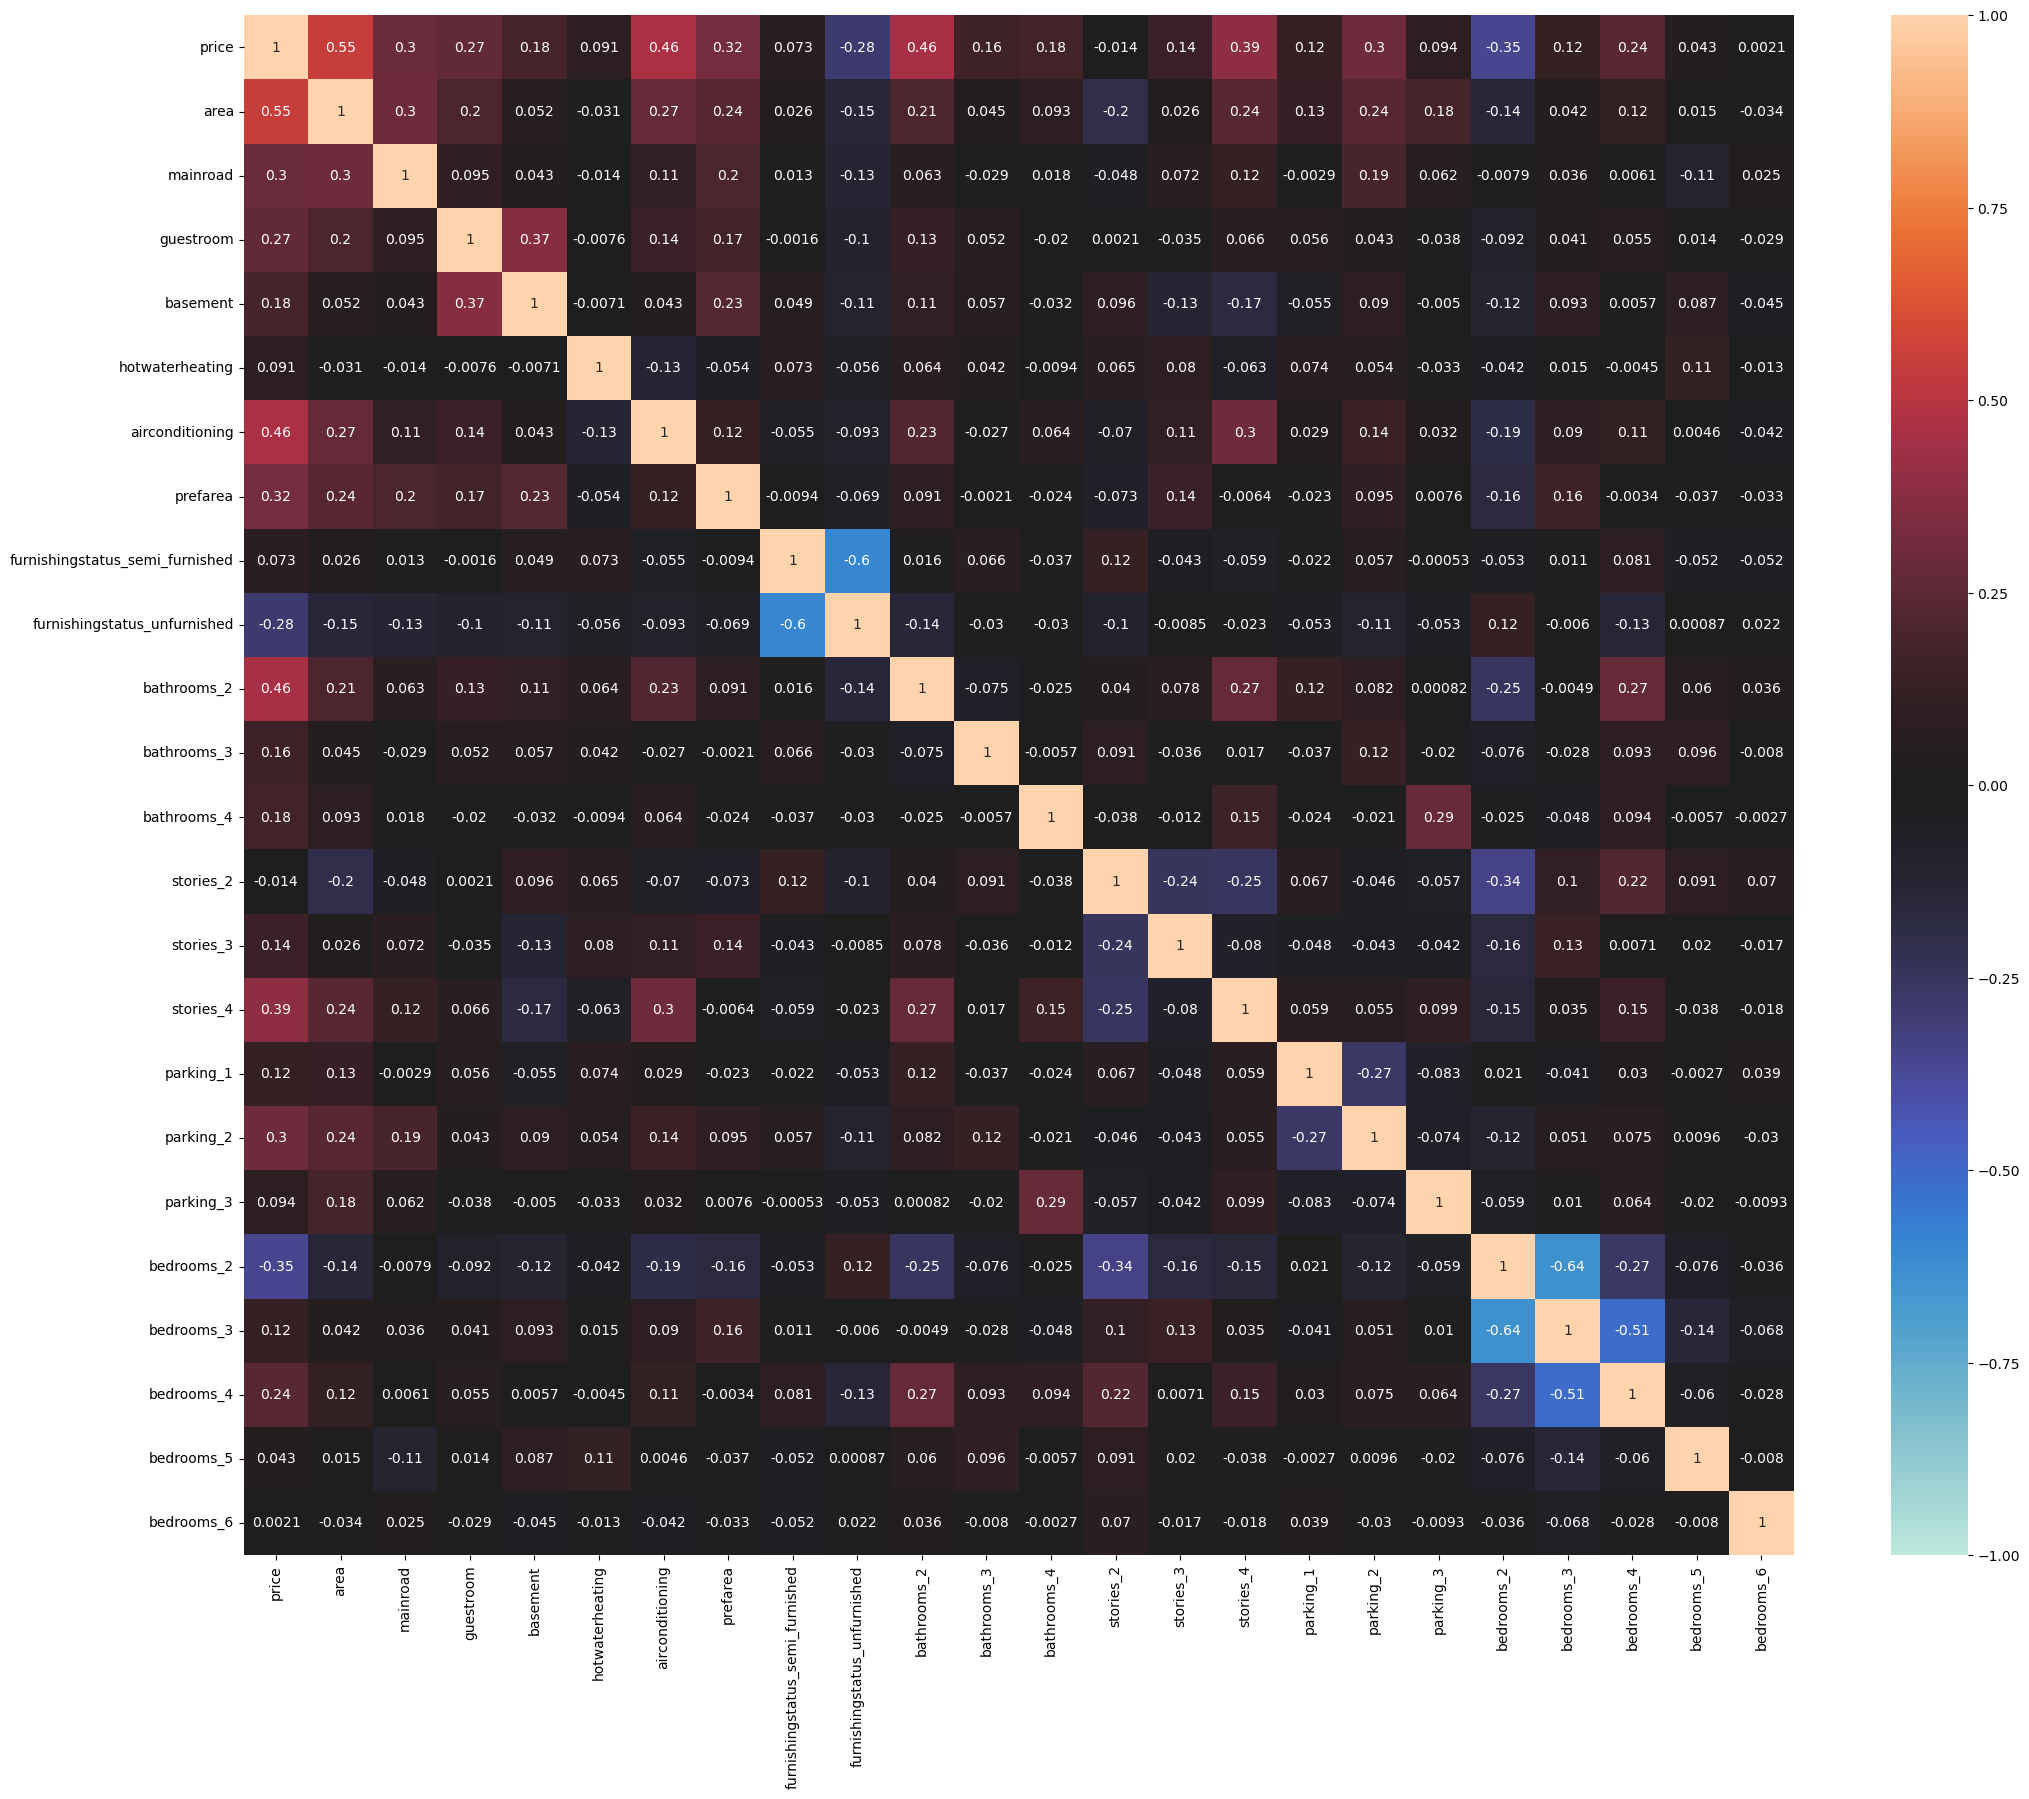

In [14]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

Manual Method - VIF


Dropped Features -->  ['bedrooms_3', 'stories_2', 'furnishingstatus_unfurnished', 'area', 'basement', 'bathrooms_2', 'airconditioning', 'bedrooms_2', 'parking_2', 'bathrooms_4', 'prefarea', 'hotwaterheating', 'mainroad', 'furnishingstatus_semi_furnished', 'bathrooms_3', 'stories_4', 'stories_3', 'parking_1', 'bedrooms_4']


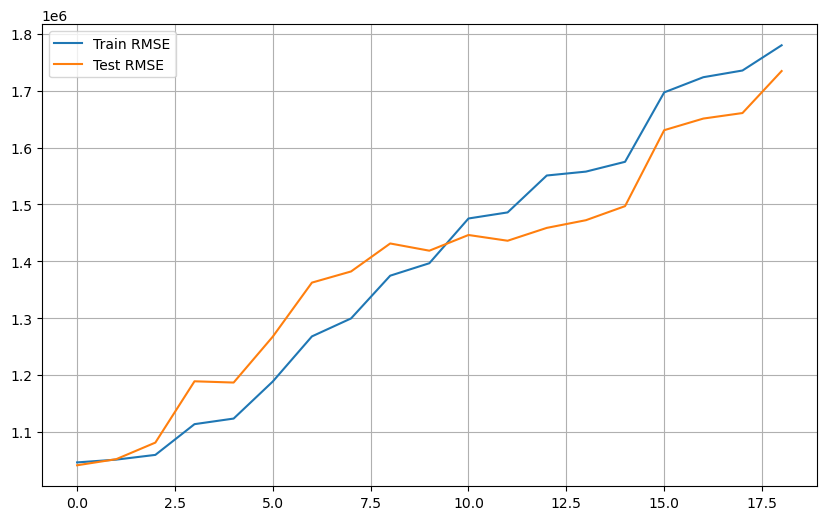

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]

DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

print('Dropped Features --> ',DROP)
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

# Connecting a remote tracking URI

In [16]:
dagshub.init(repo_owner='nada912', repo_name='HousePricePredictor', mlflow=True)

Accessing as nada912

Initialized MLflow to track repo "nada912/HousePricePredictor"

Repository nada912/HousePricePredictor initialized!

# Predictive modeling

Now adding MLFlow

In [17]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/nada912/HousePricePredictor.mlflow")

In [18]:
def Evaluate(n, pred1, pred2, run_name="Model Evaluation"):
    global Model_Evaluation_Comparison_Matrix, rc

    # Validate shapes of inputs
    assert len(Train_Y) == len(pred1), "Mismatch: Train_Y and pred1 lengths do not match."
    assert len(Test_Y) == len(pred2), "Mismatch: Test_Y and pred2 lengths do not match."

    # Safeguard for column selection
    rc = np.random.choice(
        Train_X_std.loc[:, Train_X_std.nunique() >= 50].columns.values, 
        1, 
        replace=False
    )

    # Plot predictions alongside actual values
    plt.figure(figsize=[15, 6])
    for e, i in enumerate(rc):
        plt.subplot(2, 3, e + 1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    # Evaluation metrics
    train_r2 = round(r2_score(Train_Y, pred1), 5)
    test_r2 = round(r2_score(Test_Y, pred2), 5)
    train_rss = round(np.sum(np.square(Train_Y - pred1)), 5)
    test_rss = round(np.sum(np.square(Test_Y - pred2)), 5)
    train_mse = round(mean_squared_error(Train_Y, pred1), 5)
    test_mse = round(mean_squared_error(Test_Y, pred2), 5)
    train_rmse = round(np.sqrt(train_mse), 5)
    test_rmse = round(np.sqrt(test_mse), 5)

    # Update comparison matrix
    Model_Evaluation_Comparison_Matrix.loc[n, :] = [
        train_r2, test_r2, train_rss, test_rss, train_mse, test_mse, train_rmse, test_rmse
    ]

    print('\n\n{}Training Set Metrics{}'.format('-' * 20, '-' * 20))
    print(f'R2-Score on Training set ---> {train_r2}')
    print(f'Residual Sum of Squares (RSS) on Training set  ---> {train_rss}')
    print(f'Mean Squared Error (MSE) on Training set       ---> {train_mse}')
    print(f'Root Mean Squared Error (RMSE) on Training set ---> {train_rmse}')

    print('\n{}Testing Set Metrics{}'.format('-' * 20, '-' * 20))
    print(f'R2-Score on Testing set ---> {test_r2}')
    print(f'Residual Sum of Squares (RSS) on Testing set  ---> {test_rss}')
    print(f'Mean Squared Error (MSE) on Testing set       ---> {test_mse}')
    print(f'Root Mean Squared Error (RMSE) on Testing set ---> {test_rmse}')

    # Residual plots
    print('\n{}Residual Plots{}'.format('-' * 20, '-' * 20))
    plt.figure(figsize=[15, 4])
    plt.subplot(1, 2, 1)
    sns.distplot((Train_Y - pred1), kde=True, hist=True)
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1, 2, 2)
    plt.scatter(Train_Y, pred1)
    plt.plot([Train_Y.min(), Train_Y.max()], [Train_Y.min(), Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

    # Log metrics and artifacts to MLflow
    with mlflow.start_run(run_name=run_name, nested=True):
        mlflow.log_metric("Train R2", train_r2)
        mlflow.log_metric("Test R2", test_r2)
        mlflow.log_metric("Train RSS", train_rss)
        mlflow.log_metric("Test RSS", test_rss)
        mlflow.log_metric("Train MSE", train_mse)
        mlflow.log_metric("Test MSE", test_mse)
        mlflow.log_metric("Train RMSE", train_rmse)
        mlflow.log_metric("Test RMSE", test_rmse)


## Multiple Linear Regression(MLR)

In [19]:
# Set MLflow experiment name. This will get created if it doesn't exist
experiment_name = "LinearRegressionExperiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/6902e7e6c1744c3a8ea0f21e5d5fd516', creation_time=1737668989469, experiment_id='1', last_update_time=1737668989469, lifecycle_stage='active', name='LinearRegressionExperiment', tags={}>

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>
The Coefficient of the Regression Model is: [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099925  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
The Intercept of the Regression Model is: 4716708.779342723


2025/01/24 00:28:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


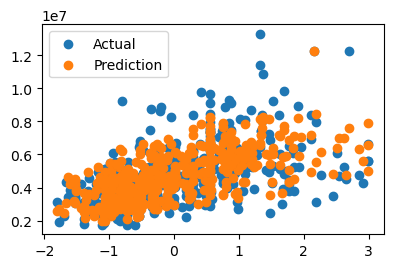



--------------------Training Set Metrics--------------------
R2-Score on Training set ---> 0.67891
Residual Sum of Squares (RSS) on Training set  ---> 466429810296572.75
Mean Squared Error (MSE) on Training set       ---> 1094905657973.1754
Root Mean Squared Error (RMSE) on Training set ---> 1046377.39749

--------------------Testing Set Metrics--------------------
R2-Score on Testing set ---> 0.68668
Residual Sum of Squares (RSS) on Testing set  ---> 116042808105904.75
Mean Squared Error (MSE) on Testing set       ---> 1084512225288.8292
Root Mean Squared Error (RMSE) on Testing set ---> 1041399.16713

--------------------Residual Plots--------------------


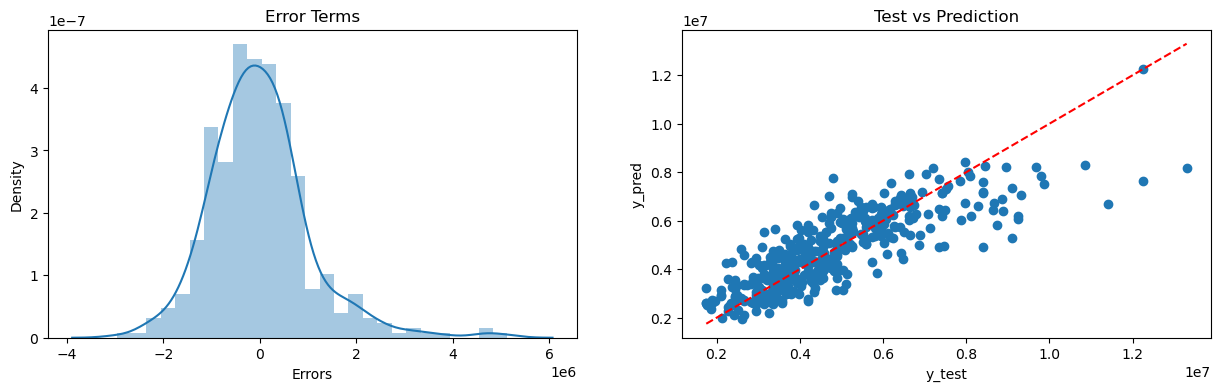

🏃 View run Linear Regression Evaluation at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/1/runs/36edccfc6995416083f9bca32f0cf410
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/1
🏃 View run Linear Regression Model at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/1/runs/5b4dc6f32727450f8504e9106ee6b278
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/1


In [21]:
# Ensure any existing run is ended
if mlflow.active_run():
    mlflow.end_run()

# Define the Model_Evaluation_Comparison_Matrix DataFrame
Model_Evaluation_Comparison_Matrix = pd.DataFrame(columns=[
    'Train-R2', 'Test-R2', 'Train-RSS', 'Test-RSS', 'Train-MSE', 'Test-MSE', 'Train-RMSE', 'Test-RMSE'
])

# Start a new MLflow run
with mlflow.start_run(run_name="Linear Regression Model", nested=True):
    # Train the model
    MLR = LinearRegression().fit(Train_X_std, Train_Y)
    pred1 = MLR.predict(Train_X_std)  # Predictions on training set
    pred2 = MLR.predict(Test_X_std)  # Predictions on testing set

    # Log model parameters
    mlflow.log_param("Model Type", "Linear Regression")
    mlflow.log_param("Features", Train_X_std.columns.tolist())
    mlflow.log_param("Coefficient", MLR.coef_.tolist())
    mlflow.log_param("Intercept", MLR.intercept_)

    print(f"\033[1m{'<'*3}{'-'*35} Evaluating Multiple Linear Regression Model {'-'*35}{'>'*3}\033[0m")
    print('The Coefficient of the Regression Model is:', MLR.coef_)
    print('The Intercept of the Regression Model is:', MLR.intercept_)

    # Log the trained model to MLflow
    mlflow.sklearn.log_model(MLR, artifact_path="linear_regression_model")

    # Call the Evaluate function and log the results
    Evaluate(0, pred1, pred2, run_name="Linear Regression Evaluation")


Register the model

In [22]:
model_name="LinearRegressionModel"
run_id="913781e20ef64a319ba07090c7a164cd"
model_uri = f"runs:/{run_id}/{model_name}"
response = mlflow.register_model(model_uri, model_name)

Registered model 'LinearRegressionModel' already exists. Creating a new version of this model...
2025/01/24 00:28:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LinearRegressionModel, version 2
Created version '2' of model 'LinearRegressionModel'.


Load the model

In [23]:
logged_model = 'runs:/913781e20ef64a319ba07090c7a164cd/linear_regression_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on your data.
data = Test_X_std
loaded_model.predict(data)

array([3878138.79607886, 3520871.68145824, 5188368.61248977,
       4434786.02184047, 5322323.81589455, 4392544.76378111,
       5407437.21704117, 3917079.77108496, 1978801.49069488,
       4870203.482845  , 5628365.79915054, 7627321.8096344 ,
       5091255.96430657, 9088391.65021869, 4047407.01517964,
       4601802.28264153, 6338381.51372079, 3431457.49034884,
       5998808.8719164 , 4521794.17861902, 3005259.32685773,
       2580685.9381423 , 3287764.3371733 , 3656964.20217648,
       6965822.53946195, 6582349.14542347, 6528226.79011748,
       4869545.75589981, 6657144.45923341, 5096898.29225984,
       2698589.37092309, 4275339.7121054 , 4247325.57549976,
       6389709.63882376, 2698589.37092309, 4892672.57687489,
       2751731.25958953, 5905255.27420019, 5145961.99267647,
       7028361.51613175, 2887522.51934359, 4062107.20328134,
       4338034.19316224, 6526731.50309469, 6428566.1776099 ,
       4928679.94863313, 7373935.26578663, 5213538.20122152,
       4187544.27651774,

## Ridge Regression Model

In [24]:
experiment_name = "RidgeRegressionExperiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/0564c4ae19cc444e82203c0e4394cfe9', creation_time=1737670782400, experiment_id='2', last_update_time=1737670782400, lifecycle_stage='active', name='RidgeRegressionExperiment', tags={}>

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>
The Coefficient of the Regression Model is: [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099925  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
The Intercept of the Regression Model is: 4716708.779342723


2025/01/24 00:29:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


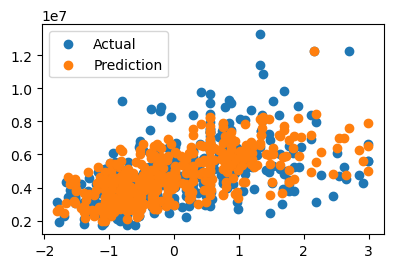



--------------------Training Set Metrics--------------------
R2-Score on Training set ---> 0.67891
Residual Sum of Squares (RSS) on Training set  ---> 466435055740620.5
Mean Squared Error (MSE) on Training set       ---> 1094917971222.1139
Root Mean Squared Error (RMSE) on Training set ---> 1046383.28122

--------------------Testing Set Metrics--------------------
R2-Score on Testing set ---> 0.68681
Residual Sum of Squares (RSS) on Testing set  ---> 115994836575477.7
Mean Squared Error (MSE) on Testing set       ---> 1084063893228.7635
Root Mean Squared Error (RMSE) on Testing set ---> 1041183.89021

--------------------Residual Plots--------------------


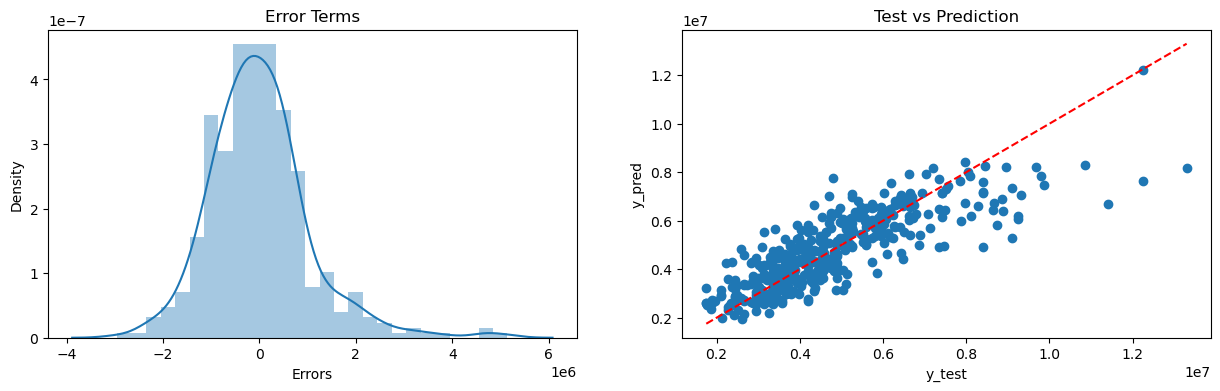

🏃 View run Ridge Regression Evaluation at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/2/runs/a4e09619185a469caa140dcd33f278bb
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/2
🏃 View run Ridge Regression Model at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/2/runs/f0264e8322824715a332de077107835f
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/2


In [25]:
# Ensure any existing run is ended
if mlflow.active_run():
    mlflow.end_run()

# Start a new MLflow run
with mlflow.start_run(run_name="Ridge Regression Model", nested=True):
    # Train the model
    RLR = Ridge().fit(Train_X_std,Train_Y)
    pred1 = RLR.predict(Train_X_std)
    pred2 = RLR.predict(Test_X_std)
    # Log model parameters
    mlflow.log_param("Model Type", "Ridge Regression")
    mlflow.log_param("Features", Train_X_std.columns.tolist())
    mlflow.log_param("Coefficient", MLR.coef_.tolist())
    mlflow.log_param("Intercept", MLR.intercept_)

    print(f"\033[1m{'<'*3}{'-'*35} Evaluating Ridge Regression Model {'-'*35}{'>'*3}\033[0m")
    print('The Coefficient of the Regression Model is:', MLR.coef_)
    print('The Intercept of the Regression Model is:', MLR.intercept_)

    # Log the trained model to MLflow
    mlflow.sklearn.log_model(MLR, artifact_path="ridge_regression_model")

    # Call the Evaluate function and log the results
    Evaluate(0, pred1, pred2, run_name="Ridge Regression Evaluation")


Register the model

In [26]:
model_name="RidgeRegressionModel"
run_id="df5a578cec7c4304978c9300f9f70c05"
model_uri = f"runs:/{run_id}/{model_name}"
response = mlflow.register_model(model_uri, model_name)

Registered model 'RidgeRegressionModel' already exists. Creating a new version of this model...
2025/01/24 00:29:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RidgeRegressionModel, version 2
Created version '2' of model 'RidgeRegressionModel'.


Load the model

In [27]:
logged_model = 'runs:/df5a578cec7c4304978c9300f9f70c05/ridge_regression_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on your data.
data = Test_X_std
loaded_model.predict(data)

array([3878138.79607886, 3520871.68145824, 5188368.61248977,
       4434786.02184047, 5322323.81589455, 4392544.76378111,
       5407437.21704117, 3917079.77108496, 1978801.49069488,
       4870203.482845  , 5628365.79915054, 7627321.8096344 ,
       5091255.96430657, 9088391.65021869, 4047407.01517964,
       4601802.28264153, 6338381.51372079, 3431457.49034884,
       5998808.8719164 , 4521794.17861902, 3005259.32685773,
       2580685.9381423 , 3287764.3371733 , 3656964.20217648,
       6965822.53946195, 6582349.14542347, 6528226.79011748,
       4869545.75589981, 6657144.45923341, 5096898.29225984,
       2698589.37092309, 4275339.7121054 , 4247325.57549976,
       6389709.63882376, 2698589.37092309, 4892672.57687489,
       2751731.25958953, 5905255.27420019, 5145961.99267647,
       7028361.51613175, 2887522.51934359, 4062107.20328134,
       4338034.19316224, 6526731.50309469, 6428566.1776099 ,
       4928679.94863313, 7373935.26578663, 5213538.20122152,
       4187544.27651774,

## Lasso Regression Model

In [28]:
experiment_name = "LassoRegressionExperiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/b86fe98781f14aeb82839cb7ea037c2b', creation_time=1737671274801, experiment_id='3', last_update_time=1737671274801, lifecycle_stage='active', name='LassoRegressionExperiment', tags={}>

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>
The Coefficient of the Regression Model is: [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099925  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
The Intercept of the Regression Model is: 4716708.779342723


2025/01/24 00:30:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


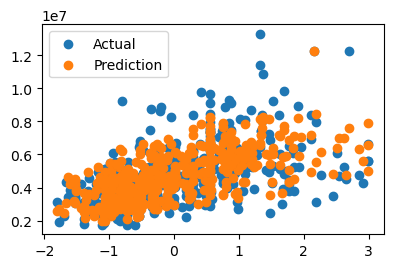



--------------------Training Set Metrics--------------------
R2-Score on Training set ---> 0.67891
Residual Sum of Squares (RSS) on Training set  ---> 466429810475643.56
Mean Squared Error (MSE) on Training set       ---> 1094905658393.5293
Root Mean Squared Error (RMSE) on Training set ---> 1046377.39769

--------------------Testing Set Metrics--------------------
R2-Score on Testing set ---> 0.68668
Residual Sum of Squares (RSS) on Testing set  ---> 116042453864706.62
Mean Squared Error (MSE) on Testing set       ---> 1084508914623.4264
Root Mean Squared Error (RMSE) on Testing set ---> 1041397.5776

--------------------Residual Plots--------------------


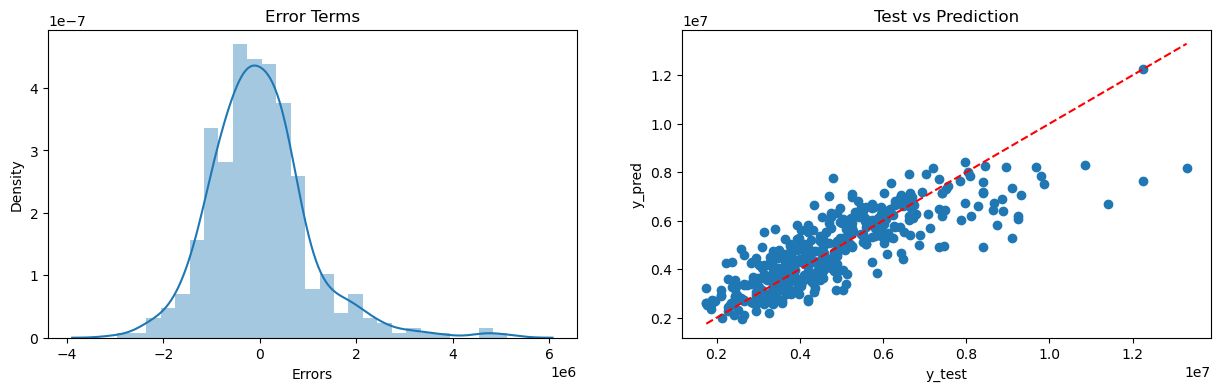

🏃 View run Lasso Regression Evaluation at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/3/runs/0e2f95bff4074d4eac55b6eec7ad8fc4
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/3
🏃 View run Lasso Regression Model at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/3/runs/39f81966409f4457a63cca292298544b
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/3


In [29]:
# Ensure any existing run is ended
if mlflow.active_run():
    mlflow.end_run()

# Start a new MLflow run
with mlflow.start_run(run_name="Lasso Regression Model", nested=True):
    # Train the model
    LLR = Lasso().fit(Train_X_std,Train_Y)
    pred1 = LLR.predict(Train_X_std)
    pred2 = LLR.predict(Test_X_std)
    # Log model parameters
    mlflow.log_param("Model Type", "Lasso Regression")
    mlflow.log_param("Features", Train_X_std.columns.tolist())
    mlflow.log_param("Coefficient", MLR.coef_.tolist())
    mlflow.log_param("Intercept", MLR.intercept_)

    print(f"\033[1m{'<'*3}{'-'*35} Evaluating Lasso Regression Model {'-'*35}{'>'*3}\033[0m")
    print('The Coefficient of the Regression Model is:', MLR.coef_)
    print('The Intercept of the Regression Model is:', MLR.intercept_)

    # Log the trained model to MLflow
    mlflow.sklearn.log_model(MLR, artifact_path="lasso_regression_model")

    # Call the Evaluate function and log the results
    Evaluate(0, pred1, pred2, run_name="Lasso Regression Evaluation")


Register the model

In [30]:
model_name="LassoRegressionModel"
run_id="39a8869f1acb4df98397c364535d3bf6"
model_uri = f"runs:/{run_id}/{model_name}"
response = mlflow.register_model(model_uri, model_name)

Registered model 'LassoRegressionModel' already exists. Creating a new version of this model...
2025/01/24 00:30:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LassoRegressionModel, version 2
Created version '2' of model 'LassoRegressionModel'.


Load the model

In [31]:
logged_model = 'runs:/39a8869f1acb4df98397c364535d3bf6/lasso_regression_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on your data.
data = Test_X_std
loaded_model.predict(data)

array([3878138.79607886, 3520871.68145824, 5188368.61248977,
       4434786.02184047, 5322323.81589455, 4392544.76378111,
       5407437.21704117, 3917079.77108496, 1978801.49069488,
       4870203.482845  , 5628365.79915054, 7627321.8096344 ,
       5091255.96430657, 9088391.65021869, 4047407.01517964,
       4601802.28264153, 6338381.51372079, 3431457.49034884,
       5998808.8719164 , 4521794.17861902, 3005259.32685773,
       2580685.9381423 , 3287764.3371733 , 3656964.20217648,
       6965822.53946195, 6582349.14542347, 6528226.79011748,
       4869545.75589981, 6657144.45923341, 5096898.29225984,
       2698589.37092309, 4275339.7121054 , 4247325.57549976,
       6389709.63882376, 2698589.37092309, 4892672.57687489,
       2751731.25958953, 5905255.27420019, 5145961.99267647,
       7028361.51613175, 2887522.51934359, 4062107.20328134,
       4338034.19316224, 6526731.50309469, 6428566.1776099 ,
       4928679.94863313, 7373935.26578663, 5213538.20122152,
       4187544.27651774,

## Elastic-Net Regression

In [32]:
experiment_name = "ElasticNetExperiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/0f7d0a76362c44699b1a9a063623dda2', creation_time=1737671540214, experiment_id='4', last_update_time=1737671540214, lifecycle_stage='active', name='ElasticNetExperiment', tags={}>

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>
The Coefficient of the Regression Model is: [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099925  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
The Intercept of the Regression Model is: 4716708.779342723


2025/01/24 00:30:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


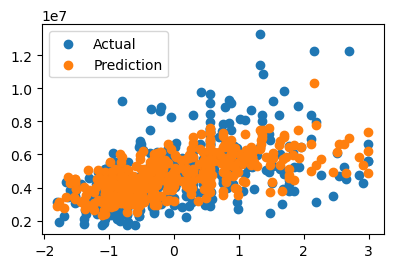



--------------------Training Set Metrics--------------------
R2-Score on Training set ---> 0.65185
Residual Sum of Squares (RSS) on Training set  ---> 505741406591209.4
Mean Squared Error (MSE) on Training set       ---> 1187186400448.8484
Root Mean Squared Error (RMSE) on Training set ---> 1089580.83704

--------------------Testing Set Metrics--------------------
R2-Score on Testing set ---> 0.67392
Residual Sum of Squares (RSS) on Testing set  ---> 120769702363881.02
Mean Squared Error (MSE) on Testing set       ---> 1128688807139.075
Root Mean Squared Error (RMSE) on Testing set ---> 1062397.66902

--------------------Residual Plots--------------------


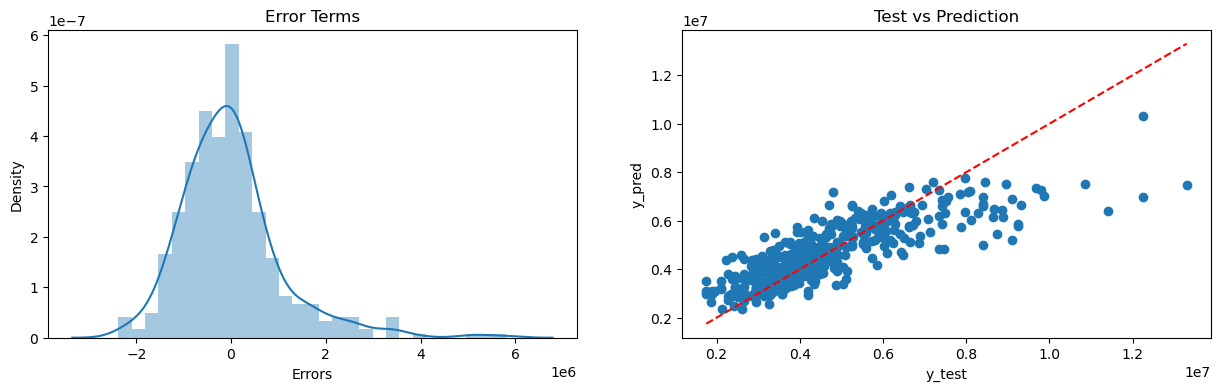

🏃 View run Elastic-Net Regression Evaluation at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/4/runs/c5b3199d22984043b7f692b9a9544690
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/4
🏃 View run Elastic-Net Regression Model at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/4/runs/3e588f7006264148b8721cc729338462
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/4


In [33]:
# Ensure any existing run is ended
if mlflow.active_run():
    mlflow.end_run()

# Start a new MLflow run
with mlflow.start_run(run_name="Elastic-Net Regression Model", nested=True):
    # Train the model
    ENR = ElasticNet().fit(Train_X_std,Train_Y)
    pred1 = ENR.predict(Train_X_std)
    pred2 = ENR.predict(Test_X_std)
    # Log model parameters
    mlflow.log_param("Model Type", "Elastic-Net Regression")
    mlflow.log_param("Features", Train_X_std.columns.tolist())
    mlflow.log_param("Coefficient", MLR.coef_.tolist())
    mlflow.log_param("Intercept", MLR.intercept_)

    print(f"\033[1m{'<'*3}{'-'*35} Evaluating Elastic-Net Regression Model {'-'*35}{'>'*3}\033[0m")
    print('The Coefficient of the Regression Model is:', MLR.coef_)
    print('The Intercept of the Regression Model is:', MLR.intercept_)

    # Log the trained model to MLflow
    mlflow.sklearn.log_model(MLR, artifact_path="elastic_net_regression_model")

    # Call the Evaluate function and log the results
    Evaluate(0, pred1, pred2, run_name="Elastic-Net Regression Evaluation")


Register the model

In [34]:
model_name="ElasticNetModel"
run_id="5ffc3ed41f76405195af6c66572bdb4c"
model_uri = f"runs:/{run_id}/{model_name}"
response = mlflow.register_model(model_uri, model_name)

Registered model 'ElasticNetModel' already exists. Creating a new version of this model...
2025/01/24 00:30:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ElasticNetModel, version 2
Created version '2' of model 'ElasticNetModel'.


Load the model

In [35]:
logged_model = 'runs:/5ffc3ed41f76405195af6c66572bdb4c/elastic_net_regression_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on your data.
data = Test_X_std
loaded_model.predict(data)

array([3878138.79607886, 3520871.68145824, 5188368.61248977,
       4434786.02184047, 5322323.81589455, 4392544.76378111,
       5407437.21704117, 3917079.77108496, 1978801.49069488,
       4870203.482845  , 5628365.79915054, 7627321.8096344 ,
       5091255.96430657, 9088391.65021869, 4047407.01517964,
       4601802.28264153, 6338381.51372079, 3431457.49034884,
       5998808.8719164 , 4521794.17861902, 3005259.32685773,
       2580685.9381423 , 3287764.3371733 , 3656964.20217648,
       6965822.53946195, 6582349.14542347, 6528226.79011748,
       4869545.75589981, 6657144.45923341, 5096898.29225984,
       2698589.37092309, 4275339.7121054 , 4247325.57549976,
       6389709.63882376, 2698589.37092309, 4892672.57687489,
       2751731.25958953, 5905255.27420019, 5145961.99267647,
       7028361.51613175, 2887522.51934359, 4062107.20328134,
       4338034.19316224, 6526731.50309469, 6428566.1776099 ,
       4928679.94863313, 7373935.26578663, 5213538.20122152,
       4187544.27651774,

## Polynomial Regression Model

In [36]:
experiment_name = "PolynomialRegressionExperiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/8e8e58de413d4c96953605e45c700bb2', creation_time=1737671863575, experiment_id='5', last_update_time=1737671863575, lifecycle_stage='active', name='PolynomialRegressionExperiment', tags={}>

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>
The Coefficient of the Regression Model is: [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099925  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
The Intercept of the Regression Model is: 4716708.779342723


2025/01/24 00:31:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


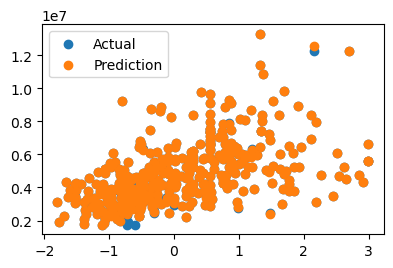



--------------------Training Set Metrics--------------------
R2-Score on Training set ---> 0.99551
Residual Sum of Squares (RSS) on Training set  ---> 6521760606447.494
Mean Squared Error (MSE) on Training set       ---> 15309297198.23356
Root Mean Squared Error (RMSE) on Training set ---> 123730.74476

--------------------Testing Set Metrics--------------------
R2-Score on Testing set ---> -1.980010511813957e+17
Residual Sum of Squares (RSS) on Testing set  ---> 7.333257100585211e+31
Mean Squared Error (MSE) on Testing set       ---> 6.853511308958143e+29
Root Mean Squared Error (RMSE) on Testing set ---> 827859366617189.6

--------------------Residual Plots--------------------


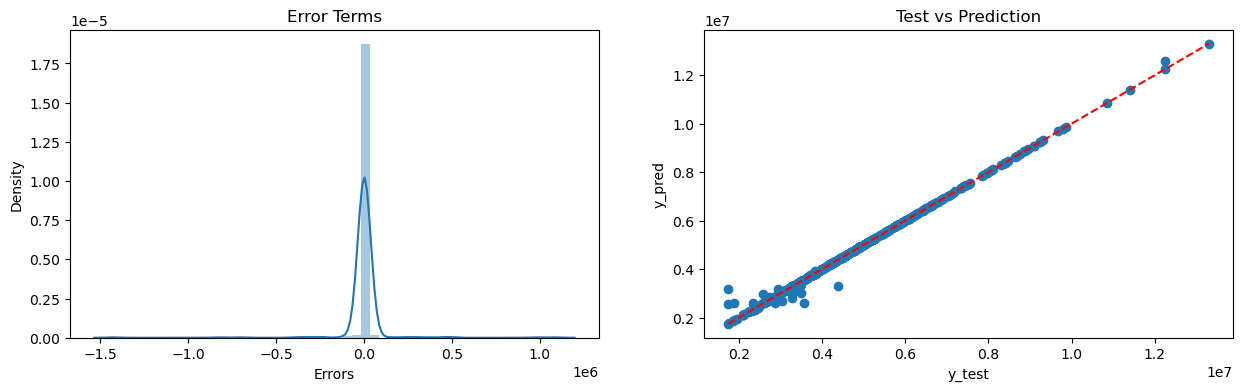

🏃 View run Polynomial Regression Evaluation at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/5/runs/ecd35094cd1b446aa251050c5cb949bf
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/5
🏃 View run Polynomial Regression Model at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/5/runs/d06021cb8d594083812e33d1355786f2
🧪 View experiment at: https://dagshub.com/nada912/HousePricePredictor.mlflow/#/experiments/5


In [37]:
# Ensure any existing run is ended
if mlflow.active_run():
    mlflow.end_run()

# Start a new MLflow run
with mlflow.start_run(run_name="Polynomial Regression Model", nested=True):
    # Train the model
    Trr=[]; Tss=[]
    n_degree=7

    for i in range(2,n_degree):
        poly_reg = PolynomialFeatures(degree=i)
        X_poly = poly_reg.fit_transform(Train_X_std)
        X_poly1 = poly_reg.fit_transform(Test_X_std)
        LR = LinearRegression()
        LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

    # Log model parameters
    mlflow.log_param("Model Type", "Polynomial Regression")
    mlflow.log_param("Features", Train_X_std.columns.tolist())
    mlflow.log_param("Coefficient", MLR.coef_.tolist())
    mlflow.log_param("Intercept", MLR.intercept_)

    print(f"\033[1m{'<'*3}{'-'*35} Evaluating Polynomial Regression Model {'-'*35}{'>'*3}\033[0m")
    print('The Coefficient of the Regression Model is:', MLR.coef_)
    print('The Intercept of the Regression Model is:', MLR.intercept_)

    # Log the trained model to MLflow
    mlflow.sklearn.log_model(MLR, artifact_path="polynomial_regression_model")

    # Call the Evaluate function and log the results
    Evaluate(0, pred1, pred2, run_name="Polynomial Regression Evaluation")


Register the model

In [38]:
model_name="PolynomialRegressionModel"
run_id="1f792e6d35c34afa907621b78ae211c4"
model_uri = f"runs:/{run_id}/{model_name}"
response = mlflow.register_model(model_uri, model_name)

Registered model 'PolynomialRegressionModel' already exists. Creating a new version of this model...
2025/01/24 00:31:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PolynomialRegressionModel, version 2
Created version '2' of model 'PolynomialRegressionModel'.


Load the model

In [39]:
logged_model = 'runs:/1f792e6d35c34afa907621b78ae211c4/polynomial_regression_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on your data.
data = Test_X_std
loaded_model.predict(data)

array([3878138.79607886, 3520871.68145824, 5188368.61248977,
       4434786.02184047, 5322323.81589455, 4392544.76378111,
       5407437.21704117, 3917079.77108496, 1978801.49069488,
       4870203.482845  , 5628365.79915054, 7627321.8096344 ,
       5091255.96430657, 9088391.65021869, 4047407.01517964,
       4601802.28264153, 6338381.51372079, 3431457.49034884,
       5998808.8719164 , 4521794.17861902, 3005259.32685773,
       2580685.9381423 , 3287764.3371733 , 3656964.20217648,
       6965822.53946195, 6582349.14542347, 6528226.79011748,
       4869545.75589981, 6657144.45923341, 5096898.29225984,
       2698589.37092309, 4275339.7121054 , 4247325.57549976,
       6389709.63882376, 2698589.37092309, 4892672.57687489,
       2751731.25958953, 5905255.27420019, 5145961.99267647,
       7028361.51613175, 2887522.51934359, 4062107.20328134,
       4338034.19316224, 6526731.50309469, 6428566.1776099 ,
       4928679.94863313, 7373935.26578663, 5213538.20122152,
       4187544.27651774,

# Conclusion

Here are some of the key outcomes of the training:
- The Dataset was quiet small with just 545 samples & after preprocessing 2.2% of the datasamples were dropped.
- Visualising the distribution of data & their relationships, helped us to get some insights on the feature-set.
- The features had high multicollinearity, hence in Feature Extraction step, we shortlisted the appropriate features with VIF Technique.
- Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.
- While, Polynomial Regression (Order-2) was the overfitting, yet it is safe to use multiple regression algorithm, as their scores were quiet comparable & also they're more generalisable.